[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Practical 2: Simple implementation of backprop

[Video timestamp](https://youtu.be/Z6H3zakmn6E?t=2640)

Here we implement a simple backpropagation algorithm with `numpy` for the following problem:

We generate points $(x_t,y_t)$ where $y_t= \exp(w^*x_t+b^*)$, i.e $y^*_t$ is obtained by applying a deterministic function to $x_t$ with parameters $w^*$ and $b^*$. Our goal is to recover the parameters $w^*$ and $b^*$ from the observations $(x_t,y_t)$.

To do this, we use SGD to minimize $\sum_t(y^t - \exp(w x_t+b))^2$ with respect to $w$ and $b$.

In these practicals, we will implement **Stochastic Gradient Descent with minibatches of size 1** and not Batched Gradient Descent as seen in lesson 2.

The modification to the algorithm is as follows: we want to minimize the loss given by:
$$
loss = \sum_t\underbrace{\left(\exp(w x_t+b)-y_t \right)^2}_{loss_t}.
$$

To minimize the loss we first compute the gradient of each $loss_t$:
$\frac{\partial{loss_t}}{\partial w}$, and $\frac{\partial{loss_t}}{\partial b}$.

For one epoch, **Stochastic Gradient Descent with minibatches of size 1** then updates the weigts and bias by running the following loop: 

for $t \in \{1,\dots,30\}$, 

\begin{eqnarray*}
w_{t+1}&=&w^1_{t}-\alpha\frac{\partial{loss_t}}{\partial w} \\
b_{t+1}&=&b_{t}-\alpha\frac{\partial{loss_t}}{\partial b},
\end{eqnarray*}

if $t = 30$, set $w_1=w_{31}$, and $b_1=b_{31}$.

$\alpha>0$ is called the learning rate.

Then we run several epochs...

We see that one epoch is much less costly than in the Batched Gradient Descent algorithm as you only need to have acces to one sample to make one update, whereas in the batched setting, you need to make a pass on the whole dataset to make an update. Of course, we are not computing the gradient here and the partial derivatives can be seen as noisy estimation of the gradient.

In [ ]:
# You do not need PyTorch for these practicals
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
w, b = 0.5, 2
xx = np.arange(0,1,.01)
yy = np.exp(w*xx+b)

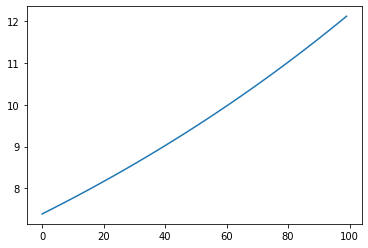

In [ ]:
plt.plot(yy)

Following what we just saw in the course, you need to implement each of the basic operations: `(.*w), (.+b), exp(.)` with a forward method, a backward method and a step method.

If you are not familiar with [classes](https://docs.python.org/3/tutorial/classes.html) in Python, you should learn its basics as it will be required to follow the rest of the course.

To help you, I have implemented the `(.+b)` operation as a Python class below:

In [ ]:
class add_bias(object):
    def __init__(self,b):
        # initialize with a bias b
        self.b = b
        
    def forward(self, x):
        # return the result of adding the bias      
        return x + self.b
    
    def backward(self,grad):
        # save the gradient (to update the bias in the step method) and return the gradient backward
        self.grad = grad
        return grad
    
    def step(self, learning_rate):
        # update the bias
        self.b -= learning_rate * self.grad        

Consider now a simpler problem where you have $z_t = x_t+b^*$ and your task is to estmiate $b^*$ by minimizing the loss $\sum_t(x_t+b-z_t)^2$ as a function of $b$ with SGD. You can use the `add_bias` defined above as follows:

In [ ]:
# first compute the z_t with a true bias of 5:
zz = xx+5

#start with an initial guess of 1 for the bias:
My_add_bias = add_bias(1)

In [ ]:
j = 10
# your predicition will be for each sample
z_pred = My_add_bias.forward(xx[j])
z_pred

1.1

In [ ]:
# start with the gradient of the quadratic loss
grad = 2*(z_pred-zz[j])

In [ ]:
# backpropagate the gradient to the parameter b
My_add_bias.backward(grad)

-7.999999999999999

In [ ]:
# make an update of the bias
My_add_bias.step(1e-2)
My_add_bias.b

1.08

The code above corresponds to one SGD update.
Below, I coded the training loop for SGD where the update on the parameter is done each time you see a sample: for each sample $j$, you compute the associated 

In [ ]:
My_add_bias = add_bias(1)
estimated_b = [1]
for i in range(500):
    # take a random indice
    j = np.random.randint(1, len(xx))
    z_pred = My_add_bias.forward(xx[j])
    grad = 2*(z_pred-zz[j])
    _ = My_add_bias.backward(grad)
    My_add_bias.step(1e-2)
    estimated_b.append(My_add_bias.b)

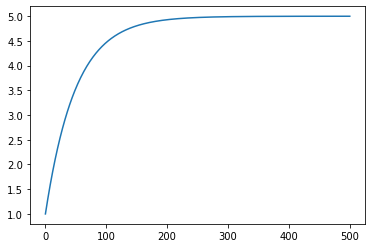

In [ ]:
plt.plot(estimated_b)

Although SGD is computing a noisy version of the gradient, we see that SGD converges to the right solution in this case.

Now it is your turn!
Following what we just saw in the course, you need to implement each of the basic operations: `(.*w), exp(.)` with a forward method, a backward method and a step method.

![backprop3](https://dataflowr.github.io/notebooks/Module2/img/backprop3.png)

In [ ]:
class multiplication_weight(object):
    def __init__(self, w):
        # initialize with a weight w
        self.w = w 
        
    def forward(self, x):
        # return the result of multiplying by weight
        self.valuex = x
        return self.w * x
               
    def backward(self,grad):
        # save the gradient and return the gradient backward
        self.grad = grad * self.valuex
        return self.grad
            
    def step(self, learning_rate):
        # update the weight
        self.w -= learning_rate * self.grad
        
class my_exp(object):
    # no parameter
    def forward(self, x):
        # return exp(x)
        self.expx = np.exp(x)
        return np.exp(x)
            
    def backward(self,grad):
        # return the gradient backward
        return grad * self.expx
            
    def step(self, learning_rate):
        # any parameter to update?
        # Hint https://docs.python.org/3/reference/simple_stmts.html#the-pass-statement
        pass
        

Now, you will need to compose sequentially these operations and here you need to code a class composing operations. This class will have a forward, a backward and a step method and also a compute_loss method.

In [ ]:
class my_composition(object):
    def __init__(self, layers):
        # initialize with all the operations (called layers here!) in the right order...
        self.layers = layers
                
    def forward(self, x):
        # apply the forward method of each layer
        for layer in self.layers:
          x = layer.forward(x)
        return x

    def compute_loss(self, y_est, y_target):
        # use the L2 loss
        # return the loss and save the gradient of the loss
        loss = (y_est - y_target)**2
        self.grad = 2 * (y_est - y_target)
        return loss
            
    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # Hint: https://docs.python.org/3/library/functions.html#reversed
        current_grad = self.grad
        for layer in reversed(self.layers):
          current_grad = layer.backward(current_grad)

    def step(self, learning_rate):
        # apply the step method of each layer
        for layer in self.layers:
          layer.step(learning_rate)        

Now you need to code the 'training' loop. Keep track of the loss, weight and bias computed at each epoch.

In [ ]:
my_fit = my_composition([multiplication_weight(1),add_bias(1), my_exp()])
learning_rate = 1e-4
losses =[]
ws = []
bs = []
for i in range(5000):
    # take a random indice
    j = np.random.randint(1, len(xx))
    # you can compare with
    #j = i % len(xx)
    # compute the estimated value of y from xx[j] with the current values of the parameters
    y_est = my_fit.forward(xx[j])
    # compute the loss and save it
    losss = my_fit.compute_loss(y_est, yy[j])
    # update the parameters 
    my_fit.backward()
    my_fit.step(learning_rate)
    #and save them
    losses.append(losss)
    ws.append(my_fit.layers[0].w)
    bs.append(my_fit.layers[1].b)

In [ ]:
my_fit.layers[0].w

0.5057928016129475

In [ ]:
my_fit.layers[1].b

1.9964089058179777

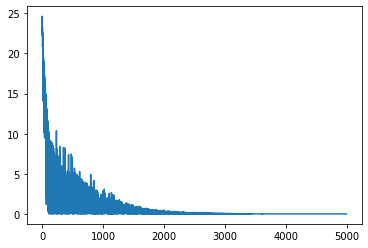

In [ ]:
plt.plot(losses)

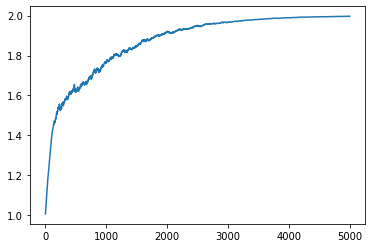

In [ ]:
plt.plot(bs)

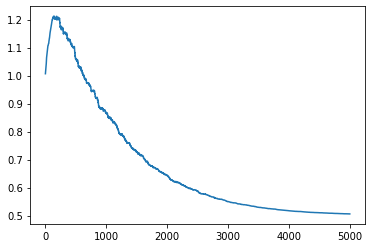

In [ ]:
plt.plot(ws)

Now you understand how Pytorch deals with automatic differentiation!!

In [ ]:
[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

SyntaxError: ignored